In [ ]:
!pip install torch torchvision matplotlib --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 16.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

dataset_path = "/content/drive/MyDrive/CelebA/celeba_hq_256"

if os.path.exists(dataset_path):
    print(" Dataset found!")
    print("Number of files:", len(os.listdir(dataset_path)))
    print("Sample files:", os.listdir(dataset_path)[:5])
else:
    print(" Folder not found! Please double-check the path.")


✅ Dataset found!
Number of files: 14520
Sample files: ['13520.jpg', '13521.jpg', '13522.jpg', '13523.jpg', '13524.jpg']


In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader


In [ ]:

dataset_path = '/content/drive/MyDrive/CelebA/celeba_hq_256'

transform = transforms.Compose([
    transforms.Resize(64),  
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  
])


In [ ]:
class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith(('.jpg', '.png'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image


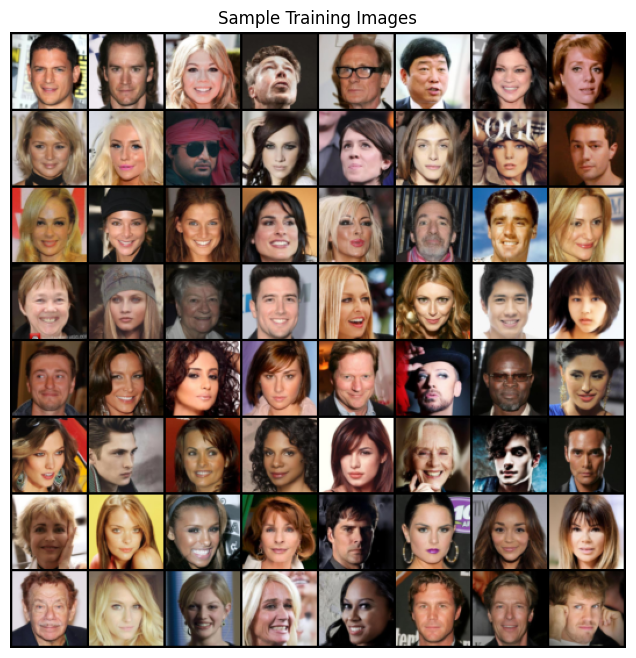

In [ ]:

dataset = CelebADataset(dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)

images = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Sample Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:64], padding=2, normalize=True), (1, 2, 0)))
plt.show()


In [ ]:

nz = 100       
ngf = 64       
ndf = 64       
nc = 3         

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

netG = Generator().to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()

lr = 0.0002
beta1 = 0.5

optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

fixed_noise = torch.randn(64, nz, 1, 1, device=device)


In [ ]:

!pip install torch torchvision matplotlib

from google.colab import drive
drive.mount('/content/drive')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:

import os

dataset_path = '/content/drive/MyDrive/CelebA/celeba_hq_256'
print("Dataset folder exists:", os.path.exists(dataset_path))
if os.path.exists(dataset_path):
    files = os.listdir(dataset_path)
    print("Number of image files:", len(files))
    print("Sample files:", files[:5])


Dataset folder exists: True
Number of image files: 14520
Sample files: ['13520.jpg', '13521.jpg', '13522.jpg', '13523.jpg', '13524.jpg']


In [ ]:

nz = 100   
ngf = 64   
ndf = 64   
nc = 3     

class Generator(nn.Module):
    def __init__(self, nz=100):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

netG = Generator(nz).to(device)
netD = Discriminator().to(device)


Using device: cuda


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os


In [ ]:

class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

nz = 100      
ngf = 64      
ndf = 64      
nc = 3        

netG = Generator(nz, ngf, nc).to(device)
netD = Discriminator(nc, ndf).to(device)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

netG.apply(weights_init)
netD.apply(weights_init)


Using device: cuda


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [ ]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.BCELoss()

lr = 0.0002
beta1 = 0.5

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

dataset_path = "/content/drive/MyDrive/CelebA/celeba_hq_256"

transform = transforms.Compose([
    transforms.Resize(64),           
    transforms.CenterCrop(64),
    transforms.ToTensor(),           
    transforms.Normalize((0.5,), (0.5,))  
])

dataset = datasets.ImageFolder(
    root=os.path.dirname(dataset_path),  
    transform=transform
)

dataset.samples = [(os.path.join(dataset_path, fname), 0) for fname in os.listdir(dataset_path)]

dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)


In [ ]:
root = "/content/drive/MyDrive/CelebA"


In [ ]:
dataset.samples = [(os.path.join(dataset_path, fname), 0) for fname in os.listdir(dataset_path)]


In [ ]:
import time

num_epochs = 5  
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label = 1.
fake_label = 0.

print("Starting Training Loop...")

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        real_images = data[0].to(device)
        b_size = real_images.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_images).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)  
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 100 == 0:
            print(f"[{epoch+1}/{num_epochs}][{i}/{len(dataloader)}] "
                  f"Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} "
                  f"D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}")


Starting Training Loop...
[1/5][0/114] Loss_D: 1.7235 Loss_G: 5.5946 D(x): 0.5497 D(G(z)): 0.5832/0.0066
[1/5][100/114] Loss_D: 0.3430 Loss_G: 7.8624 D(x): 0.8252 D(G(z)): 0.0181/0.0020
[2/5][0/114] Loss_D: 1.3436 Loss_G: 15.6397 D(x): 0.9801 D(G(z)): 0.6572/0.0000
[2/5][100/114] Loss_D: 0.2150 Loss_G: 3.2150 D(x): 0.9292 D(G(z)): 0.1096/0.0612
[3/5][0/114] Loss_D: 0.8059 Loss_G: 6.6507 D(x): 0.9759 D(G(z)): 0.4568/0.0024
[3/5][100/114] Loss_D: 1.5537 Loss_G: 4.3374 D(x): 0.3692 D(G(z)): 0.0112/0.0249
[4/5][0/114] Loss_D: 0.5875 Loss_G: 3.4812 D(x): 0.7428 D(G(z)): 0.1319/0.0516
[4/5][100/114] Loss_D: 0.7677 Loss_G: 9.8179 D(x): 0.8913 D(G(z)): 0.4052/0.0003
[5/5][0/114] Loss_D: 0.5644 Loss_G: 6.3551 D(x): 0.8794 D(G(z)): 0.2909/0.0039
[5/5][100/114] Loss_D: 0.4385 Loss_G: 3.9331 D(x): 0.9225 D(G(z)): 0.2412/0.0309


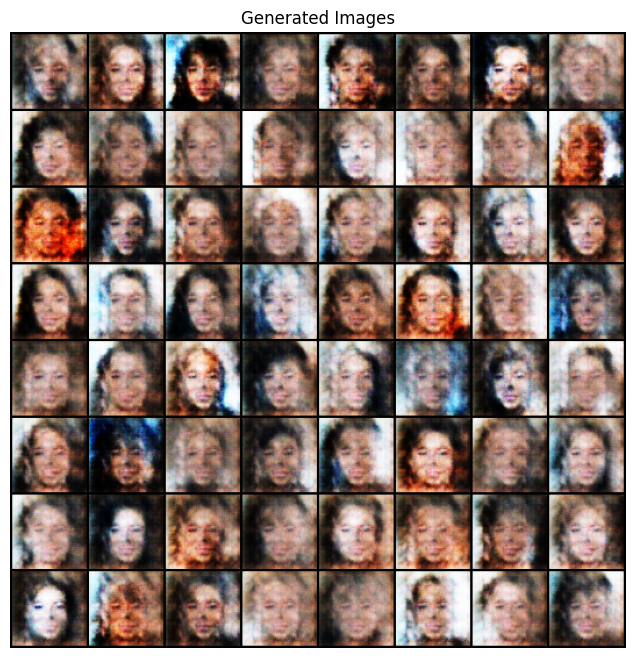

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fixed_noise = torch.randn(64, nz, 1, 1, device=device)
with torch.no_grad():
    fake_images = netG(fixed_noise).detach().cpu()

def show_generated_images(img_tensor, num_images=64):
    img_tensor = (img_tensor + 1) / 2 
    grid_img = torchvision.utils.make_grid(img_tensor[:num_images], nrow=8)
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Generated Images")
    plt.imshow(np.transpose(grid_img.numpy(), (1, 2, 0)))
    plt.show()

show_generated_images(fake_images)


In [ ]:
num_epochs = 50  


In [ ]:
torch.save(netG.state_dict(), "/content/drive/MyDrive/dcgan_generator.pth")


In [ ]:
import time

num_epochs = 150  
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label = 1.
fake_label = 0.

print("Starting Training Loop...")

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        real_images = data[0].to(device)
        b_size = real_images.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_images).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 100 == 0:
            print(f"[{epoch+1}/{num_epochs}][{i}/{len(dataloader)}] "
                  f"Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} "
                  f"D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}")


Starting Training Loop...
[1/150][0/114] Loss_D: 0.5956 Loss_G: 6.2577 D(x): 0.9220 D(G(z)): 0.3550/0.0041
[1/150][100/114] Loss_D: 1.0651 Loss_G: 2.3852 D(x): 0.4867 D(G(z)): 0.0280/0.1266
[2/150][0/114] Loss_D: 0.6238 Loss_G: 5.2904 D(x): 0.8108 D(G(z)): 0.2786/0.0080
[2/150][100/114] Loss_D: 0.7769 Loss_G: 4.0912 D(x): 0.6262 D(G(z)): 0.0290/0.0391
[3/150][0/114] Loss_D: 0.9898 Loss_G: 7.8058 D(x): 0.9382 D(G(z)): 0.4964/0.0013
[3/150][100/114] Loss_D: 0.3895 Loss_G: 5.3145 D(x): 0.8771 D(G(z)): 0.1823/0.0114
[4/150][0/114] Loss_D: 0.3767 Loss_G: 4.6543 D(x): 0.9026 D(G(z)): 0.2002/0.0180
[4/150][100/114] Loss_D: 1.1077 Loss_G: 4.4967 D(x): 0.5212 D(G(z)): 0.0352/0.0374
[5/150][0/114] Loss_D: 0.6116 Loss_G: 5.0326 D(x): 0.8634 D(G(z)): 0.3262/0.0111
[5/150][100/114] Loss_D: 1.2020 Loss_G: 2.6493 D(x): 0.4805 D(G(z)): 0.0334/0.1300
[6/150][0/114] Loss_D: 0.6093 Loss_G: 3.3403 D(x): 0.6642 D(G(z)): 0.0355/0.0643
[6/150][100/114] Loss_D: 1.4984 Loss_G: 1.7765 D(x): 0.3551 D(G(z)): 0.02

In [ ]:
!pip install pytorch-fid


In [ ]:
import os
from torchvision.utils import save_image

netG.eval()  
os.makedirs("generated_fakes", exist_ok=True)

with torch.no_grad():
    for i in range(100):
        noise = torch.randn(1, nz, 1, 1, device=device)
        fake_img = netG(noise).detach().cpu()
        save_image(fake_img, f"generated_fakes/fake_{i}.png", normalize=True)


In [ ]:
!python -m pytorch_fid generated_fakes /content/drive/MyDrive/CelebA/celeba_hq_256/



Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:00<00:00, 278MB/s]
100% 2/2 [00:00<00:00,  2.16it/s]
100% 291/291 [04:18<00:00,  1.12it/s]
FID:  161.74640176174495


In [ ]:
torch.save(netG.state_dict(), "dcgan_generator.pth")
torch.save(netD.state_dict(), "dcgan_discriminator.pth")


In [ ]:
import os
from torchvision.utils import save_image

netG.eval()
os.makedirs("generated_fakes_1000", exist_ok=True)

with torch.no_grad():
    for i in range(1000):
        noise = torch.randn(1, nz, 1, 1, device=device)
        fake_img = netG(noise).detach().cpu()
        save_image(fake_img, f"generated_fakes_1000/fake_{i}.png", normalize=True)


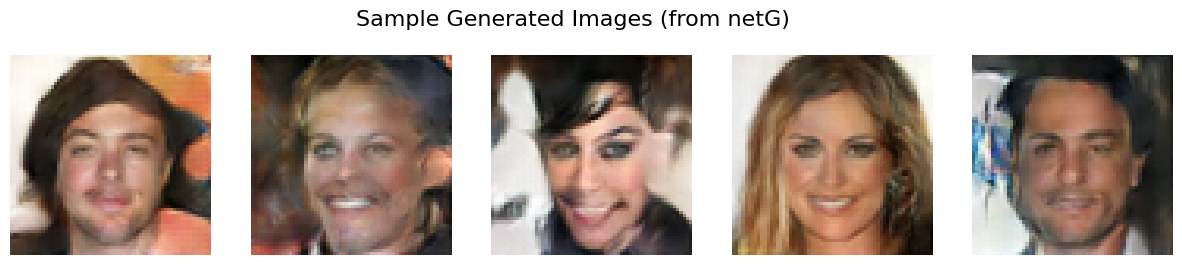

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(15, 3))
for i in range(5):
    img_path = f"generated_fakes_1000/fake_{i}.png"
    img = mpimg.imread(img_path)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
plt.suptitle("Sample Generated Images (from netG)", fontsize=16)
plt.show()


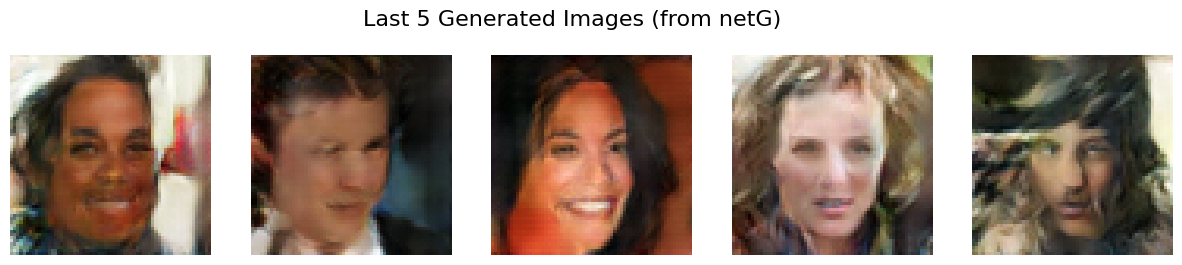

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(15, 3))
for i in range(995, 1000):
    img_path = f"generated_fakes_1000/fake_{i}.png"
    img = mpimg.imread(img_path)
    plt.subplot(1, 5, i - 994)
    plt.imshow(img)
    plt.axis("off")
plt.suptitle("Last 5 Generated Images (from netG)", fontsize=16)
plt.show()


In [ ]:
!cp -r /content/generated_fakes_1000 /content/drive/MyDrive/


In [ ]:
import os

drive_path = "/content/drive/MyDrive/generated_fakes_1000"
if os.path.exists(drive_path):
    print(" Folder exists!")
    print("Sample files:", os.listdir(drive_path)[:5])  
else:
    print(" Folder not found.")


✅ Folder exists!
Sample files: ['fake_0.png', 'fake_1.png', 'fake_2.png', 'fake_3.png', 'fake_4.png']
